# Dynamic circuits basics with Qiskit

This guide introduces how to use dynamic circuits with Qiskit.

We recommend using dynamic circuits with Qiskit, since it combines the power of Python with quantum computing in a scalable way that makes it easy to build and execute programs on IBM hardware.

## Know before you begin

Below we instantiate the Qiskit backend that we will use to submit programs to the target system. Backends provide a handle to the quantum hardware instance. Backends are obtained from the ``IBMProvider`` imported from ``qiskit_ibm_provider``, and are specified by a system name along with a ``hub/group/project`` string that will enable you to access a specific system under an access provider.

Visit [this page](https://quantum-computing.ibm.com/services/resources?tab=yours&openqasm3=true) to view the systems with dynamic circuit support.

In [1]:
# Note: This can be any hub/group/project that has access to the required device and Qiskit Runtime.
hub = "<hub>"
group = "<group>"
project = "<project>"
backend_name = "<your backend>"
hgp = f"{hub}/{group}/{project}"

# Note: If you do not have your IBM Token saved, run the following
# More info: https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq
# IBMProvider.save_account("TOKEN")
# IBMProvider.load_account()
# IBMProvider.providers()

In [2]:
from qiskit_ibm_provider import IBMProvider

# load provider and backend
provider = IBMProvider()
backend = provider.get_backend(backend_name, instance=hgp)
print(f"Using backend {backend.name}")

Below is a simple transpiled Bell circuit.

Bell states are the four states that can be created when maximally entangled. The four states are represented as:

$$|\Phi^+\rangle = \frac{|00\rangle + |11\rangle}{\sqrt{2}}$$

$$|\Phi^-\rangle = \frac{|00\rangle - |11\rangle}{\sqrt{2}}$$

$$|\Psi^+\rangle = \frac{|01\rangle + |10\rangle}{\sqrt{2}}$$

$$|\Psi^-\rangle = \frac{|01\rangle - |10\rangle}{\sqrt{2}}$$

In our example, we will implement the first Bell state. The circuit will consist of a Hadamard gate and a CNOT gate.

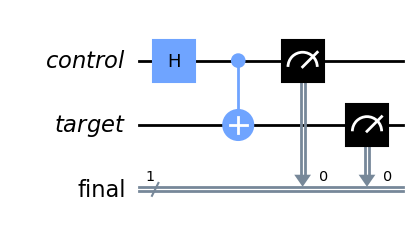

In [ ]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile

control = QuantumRegister(1, name="control")
target = QuantumRegister(1, name="target")
final_measure = ClassicalRegister(1, name="final")

# Creating a Bell circuit
qc_bell = QuantumCircuit(control, target, final_measure)
qc_bell.h(control)
qc_bell.cx(control, target)
qc_bell.measure(control, final_measure)
qc_bell.measure(target, final_measure)
qc_bell.draw(output="mpl", idle_wires=False)

Now we can transpile our circuit `qc_bell` using `transpile(qc_bell, backend)`. The transpiler rewrites an abstract quantum circuit into a functionally equivalent one that matches the constraints and characteristics of a specific target quantum device.[$^2$](https://medium.com/qiskit/how-does-the-qiskit-transpiler-work-6710863beaac) In other words, transpiling a circuit transforms a circuit to match the basis gates and coupling graph of the target backend.

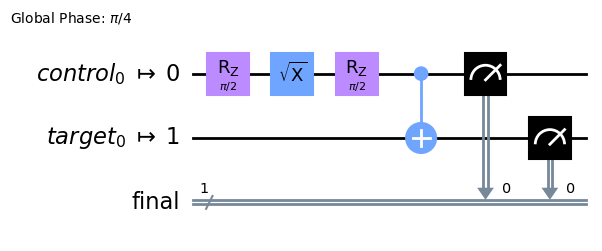

In [4]:
qc_bell = transpile(qc_bell, backend)
qc_bell.draw(output="mpl", idle_wires=False)

Now we run the program on our backend using `backend.run(<program>, shots=shots, dynamic=True)`, which returns the job, `bell_job`. 

Be sure to use the `dynamic=True` flag in your `backend.run()`. We can run both on the legacy/dynamic circuit paths to compare performance as we develop these capabilities.

In order to fetch the results of this job, we run `bell_job.result()`. This returns the number of times 0s or 1s were the output. 

In [5]:
from qiskit.tools.monitor import job_monitor

bell_job = backend.run(qc_bell, shots=1000, dynamic=True)
print(f"Runtime job id: {bell_job.job_id()}")
job_monitor(bell_job)

bell_result = bell_job.result()
print(f"Preparation results: {bell_result.get_counts(0)}")

Runtime job id: cg7r11l7vlu95bb2ib20
Job Status: job has successfully run
Preparation results: {'0': 517, '1': 483}


Plot the same preparation results as a histogram.

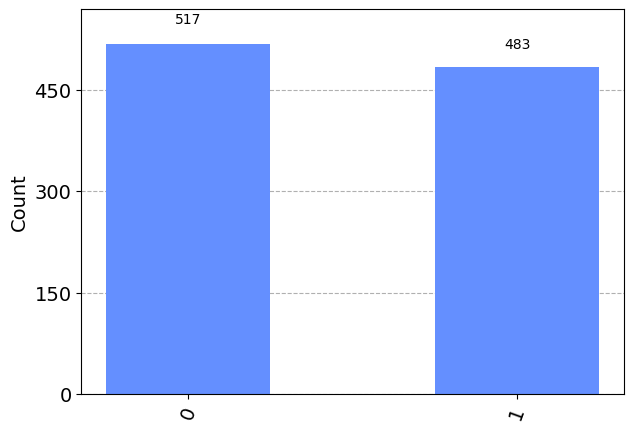

In [6]:
from qiskit.visualization import plot_histogram

plot_histogram(bell_result.get_counts(0))

## Mid-circuit measurements with dynamic circuits

Measurements are done to gather information about the final state of a quantum system in the form of a discrete probability distribution in the computational basis. However, there are distinct computational advantages to measuring a qubit in the middle of a computation. Mid-circuit measurements can be used to validate the state of a quantum computer in the presence of noise, allowing for post-selection of the final measurement outcomes based on the success of one or more sanity checks. Visit [this page](./midcircuit_measurement) for more information about mid-circuit measurement.

First, let's try a simple circuit with only an X-gate, and do a mid-circuit measurement.

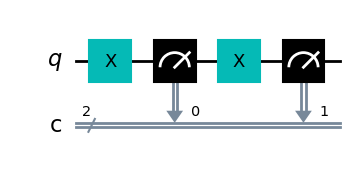

In [7]:
qc_midcirc = QuantumCircuit(1, 2)

qc_midcirc.x(0)
qc_midcirc.measure(0, 0)
qc_midcirc.x(0)
qc_midcirc.measure(0, 1)

qc_midcirc.draw(output="mpl", idle_wires=False)

Here, the result of the first measurement should be $1$. Apply an X-gate to the qubit again, and the result should be $0$.

In [8]:
qc_midcirc_transpiled = transpile(qc_midcirc, backend)

In [9]:
from qiskit.result import marginal_counts


midcirc_job = backend.run(qc_midcirc_transpiled, shots=1000, dynamic=True)
print(f"Runtime job id: {midcirc_job.job_id()}")
job_monitor(midcirc_job)

midcirc_count1 = marginal_counts(midcirc_job.result(), indices=[0]).get_counts()
midcirc_count2 = marginal_counts(midcirc_job.result(), indices=[1]).get_counts()

print(f"Measurement 1 results: {midcirc_count1}")
print(f"Measurement 2 results: {midcirc_count2}")

Runtime job id: cg7r15i14ejq4casn94g
Job Status: job has successfully run
Measurement 1 results: {'0': 13, '1': 987}
Measurement 2 results: {'0': 924, '1': 76}


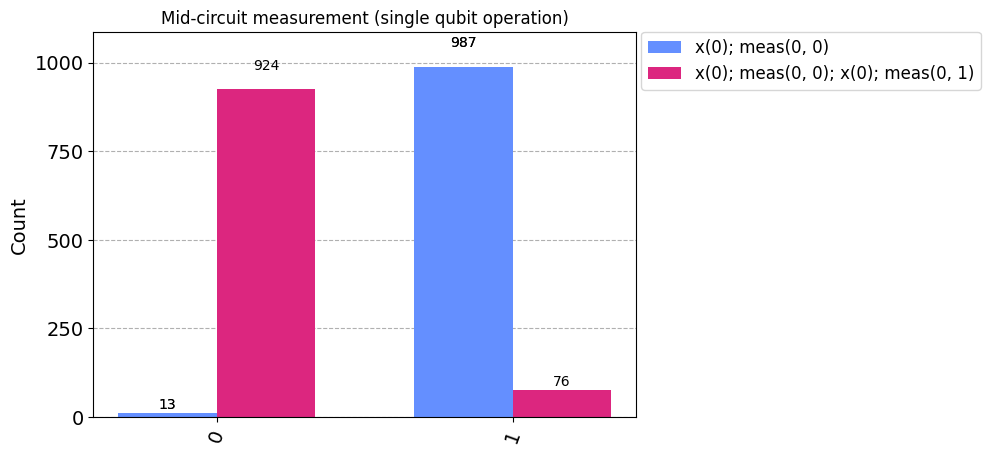

In [10]:
plot_histogram(
    [midcirc_count1, midcirc_count2],
    legend=["x(0); meas(0, 0)", "x(0); meas(0, 0); x(0); meas(0, 1)"],
    title="Mid-circuit measurement (single qubit operation)",
)

Now that we understand what mid-circuit measurement does, let's try mid-circuit measurement using an H-gate.

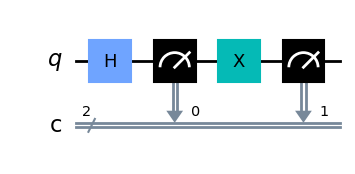

In [11]:
qc_midcirc = QuantumCircuit(1, 2)

qc_midcirc.h(0)
qc_midcirc.measure(0, 0)
qc_midcirc.x(0)
qc_midcirc.measure(0, 1)

qc_midcirc.draw(output="mpl", idle_wires=False)

In [12]:
qc_midcirc_transpiled = transpile(qc_midcirc, backend)

In [13]:
midcirc_job = backend.run(qc_midcirc_transpiled, shots=10, dynamic=True)
print(f"Runtime job id: {midcirc_job.job_id()}")
job_monitor(midcirc_job)

midcirc_count1 = marginal_counts(midcirc_job.result(), indices=[0]).get_counts()
midcirc_count2 = marginal_counts(midcirc_job.result(), indices=[1]).get_counts()

print(f"Measurement 1 results: {midcirc_count1}")
print(f"Measurement 2 results: {midcirc_count2}")

Runtime job id: cg7r18n91ascc92533gg
Job Status: job has successfully run
Measurement 1 results: {'1': 4, '0': 6}
Measurement 2 results: {'0': 4, '1': 6}


We ran `qc_midcirc_transpiled` 10 times (i.e., `shots=10`). Ideally, the first measurement would have $1$ as its outcome for $5/10$ of the shots and $0$ for the remaining 5 shots.

On average we can't tell from the histogram results that the mid-circuit measurements were correlated or not. This is why we need to look at `get_memory` to verify that $0$ is always followed by $1$ and vice-versa (up to gate/measurement errors). The `get_memory(experiment)` function returns a list containing each individual shot's measurement outcomes.

In [14]:
midcirc_job.result().get_memory(qc_midcirc)

['01', '10', '01', '01', '10', '10', '10', '01', '10', '10']

For each shot, the first bit shows the result of the first measurement and the second bit shows the result of the second measurement outcome.

Now, run the circuit with `shots=1000`.

In [15]:
midcirc_job = backend.run(qc_midcirc_transpiled, shots=1000, dynamic=True)
print(f"Runtime job id: {midcirc_job.job_id()}")
job_monitor(midcirc_job)

midcirc_count1 = marginal_counts(midcirc_job.result(), indices=[0]).get_counts()
midcirc_count2 = marginal_counts(midcirc_job.result(), indices=[1]).get_counts()

print(f"Measurement 1 results: {midcirc_count1}")
print(f"Measurement 2 results: {midcirc_count2}")

Runtime job id: cg7r1d214ejq4casnf90
Job Status: job has successfully run
Measurement 1 results: {'0': 506, '1': 494}
Measurement 2 results: {'0': 454, '1': 546}


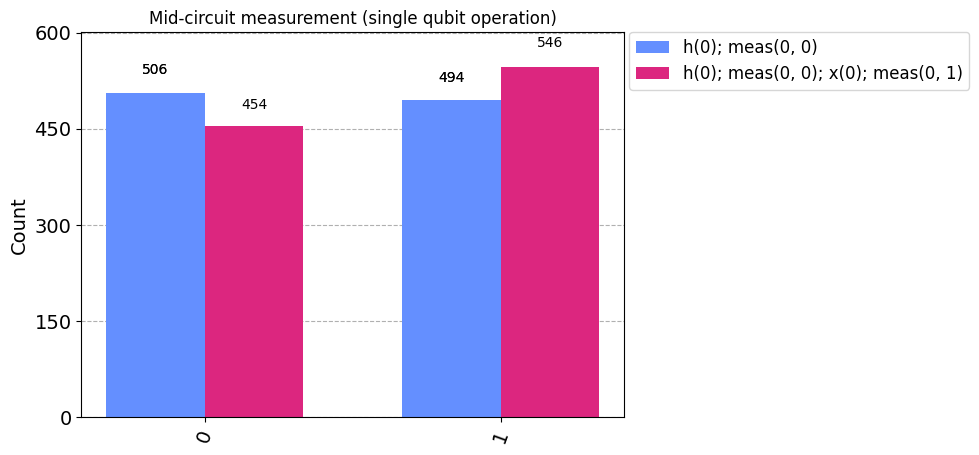

In [16]:
plot_histogram(
    [midcirc_count1, midcirc_count2],
    legend=["h(0); meas(0, 0)", "h(0); meas(0, 0); x(0); meas(0, 1)"],
    title="Mid-circuit measurement (single qubit operation)",
)

During the mid-circuit measurement (*measurement one*), $1$ and $0$ appear approximately 50\% of the time. After we apply the X-gate (*measurement two*), the results are ideally the reverse of measurement one.

## Resets with dynamic circuits

Let's learn about `reset`s using mid-circuit measurement.

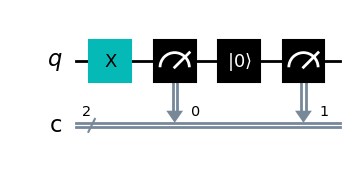

In [17]:
qc_reset = QuantumCircuit(1, 2)

qc_reset.x(0)
qc_reset.measure(0, 0)
qc_reset.reset(0)  # Applying reset here to reset the qubit back to its initial state
qc_reset.measure(0, 1)

qc_reset.draw(output="mpl", idle_wires=False)

In [18]:
qc_reset_transpiled = transpile(qc_reset, backend)

In [19]:
reset_job = backend.run(qc_reset_transpiled, shots=1000, dynamic=True)
print(f"Runtime job id: {reset_job.job_id()}")
job_monitor(reset_job)

reset_count1 = marginal_counts(reset_job.result(), indices=[0]).get_counts()
reset_count2 = marginal_counts(reset_job.result(), indices=[1]).get_counts()

print(f"Measurement 1 results: {reset_count1}")
print(f"Measurement 2 results: {reset_count2}")

Runtime job id: cg7r1iakefmul9thm9s0
Job Status: job has successfully run
Measurement 1 results: {'0': 14, '1': 986}
Measurement 2 results: {'0': 943, '1': 57}


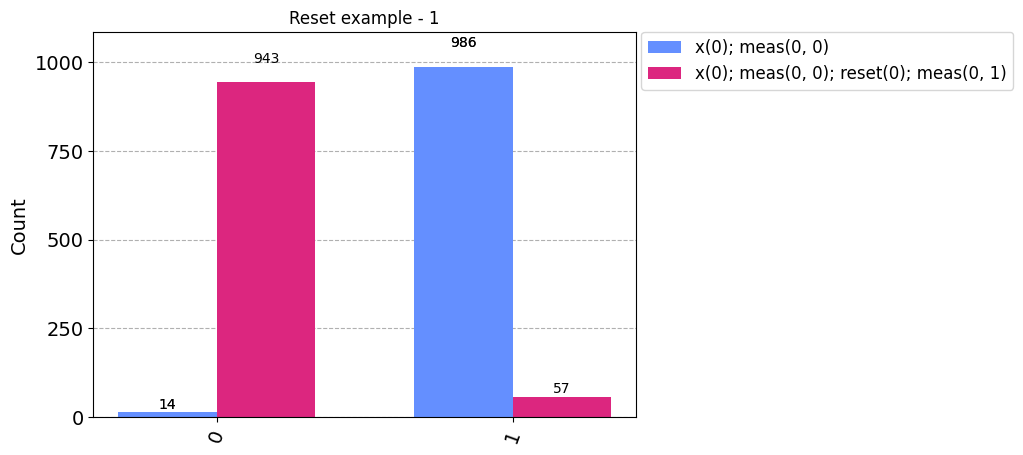

In [20]:
plot_histogram(
    [reset_count1, reset_count2],
    legend=["x(0); meas(0, 0)", "x(0); meas(0, 0); reset(0); meas(0, 1)"],
    title="Reset example - 1",
)

Apply the X-gate first to flip the initial state to $|1\rangle$, and then apply the `reset` to bring the qubits back to ground state ($|0\rangle$).

Now, let's try `reset` after an H-gate.

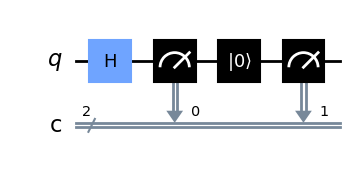

In [21]:
qc_reset = QuantumCircuit(1, 2)

qc_reset.h(0)
qc_reset.measure(0, 0)
qc_reset.reset(0)
qc_reset.measure(0, 1)

qc_reset.draw(output="mpl", idle_wires=False)

In [22]:
qc_reset_transpiled = transpile(qc_reset, backend)

In [23]:
reset_job = backend.run(qc_reset_transpiled, shots=1000, dynamic=True)
print(f"Runtime job id: {reset_job.job_id()}")
job_monitor(reset_job)

reset_count1 = marginal_counts(reset_job.result(), indices=[0]).get_counts()
reset_count2 = marginal_counts(reset_job.result(), indices=[1]).get_counts()

print(f"Measurement 1 results: {reset_count1}")
print(f"Measurement 2 results: {reset_count2}")

Runtime job id: cg7r1m2kefmul9thmc40
Job Status: job has successfully run
Measurement 1 results: {'0': 502, '1': 498}
Measurement 2 results: {'0': 959, '1': 41}


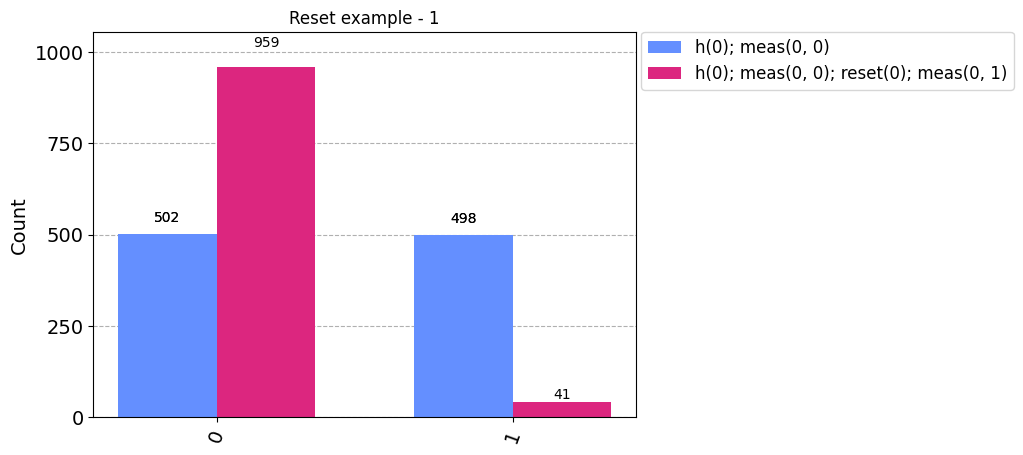

In [24]:
plot_histogram(
    [reset_count1, reset_count2],
    legend=["h(0); meas(0, 0)", "h(0); meas(0, 0); reset(0); meas(0, 1)"],
    title="Reset example - 1",
)

During the mid-circuit measurement (*measurement one*), $1$ and $0$ appear approximately 50\% of the time. After we apply the `reset` gate (*measurement two*), ideally we get $0$ 100\% of the time, which demonstrates how `reset` works. 

## Control flow

Qiskit supports various control flow operations. Visit the Qiskit [control flow operations](/api/qiskit/circuit#control-flow-operations) API documentation for more details.

### If-else condition

To program an `if/else` condition, you may use `with circuit.if_test(<condition>)`. Visit the [Qiskit API documentation](/api/qiskit/qiskit.circuit.QuantumCircuit#if_else) for more details. 

Dynamic circuit capabilities such as `if_test` come with an associated latency introduced into the control system. This is due to the need to communicate measurement outcomes and the resulting decisions (the `if_test` condition) to all of the system's qubit controllers (waveform generators/digitizers). This latency is currently on the order of 400-700 ns. We are working to minimize the latency as we develop our systems further. For more information please see the [FAQ](./getting-started-with-dynamic-circuits#faqs).

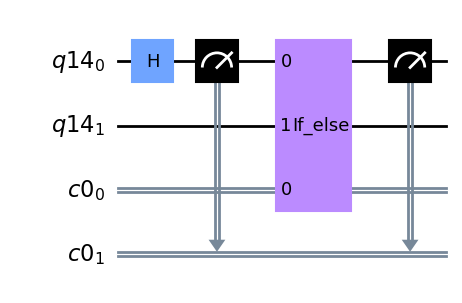

In [25]:
qr = QuantumRegister(2)
cr = ClassicalRegister(2)

qc_if_else = QuantumCircuit(qr, cr)

qc_if_else.h(0)
qc_if_else.measure(qr[0], cr[1])

with qc_if_else.if_test((cr[0], True)) as else_:
    qc_if_else.x(qr[0])
with else_:
    qc_if_else.x(qr[1])

qc_if_else.measure(qr[0], cr[1])

qc_if_else.draw(output="mpl", idle_wires=False)

Be sure to transpile the circuit.

In [26]:
qc_if_else_transpiled = transpile(qc_if_else, backend)

Run the transpiled circuit on the backend because we have an H-gate in the circuit.

In [27]:
if_else_job = backend.run(qc_if_else_transpiled, shots=1000, dynamic=True)
print(f"Runtime job id: {if_else_job.job_id()}")
job_monitor(if_else_job)

if_else_result = if_else_job.result()
print(f"Preparation results: {if_else_result.get_counts(0)}")

Runtime job id: cg7r1qi14ejq4casnnng
Job Status: job has successfully run
Preparation results: {'00': 569, '10': 431}


Plot the preparation results.

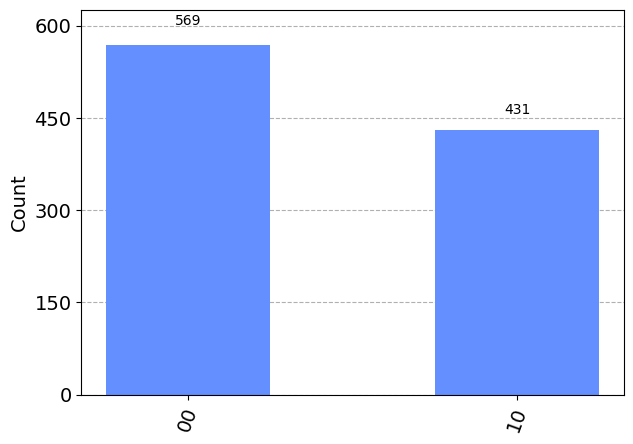

In [28]:
plot_histogram(if_else_result.get_counts(0))

[For loops](/api/qiskit/qiskit.circuit.QuantumCircuit#for_loop) and [while loops](/api/qiskit/qiskit.circuit.QuantumCircuit#while_loop) can be done in Qiskit. An efficient multi-case branch switch operation will be included in a future release.

These features are only supported on dynamic circuit backends. For more information, visit the [Dynamic Circuits basics with OpenQASM3](./dynamic-circuits-basics-with-openqasm3#for-loops) tutorial. To see what features of OpenQASM 3 are currently supported in hardware, please see the [feature table](./feature-table).

## Conditional measurements

Below is an example of a conditional measurement. Classical computation, Boolean expressions, and conditionals may be combined with qubit measurement to implement conditional measurement. Here the result of qubit measurements may be used to conditionally select additional qubit measurements. 

Conditional measurement can be done in Qiskit either with the older `circuit.x(0).c_if(<condition>)` form, or the newer `with circuit.if_test(<condition>)` form. Note that, for single operations like the above example, either will work for now, but it is beneficial to start adopting the new form, since the old form will eventually be deprecated, and the new one offers the ability to condition multiple operations together and nest control-flow in a general fashion.

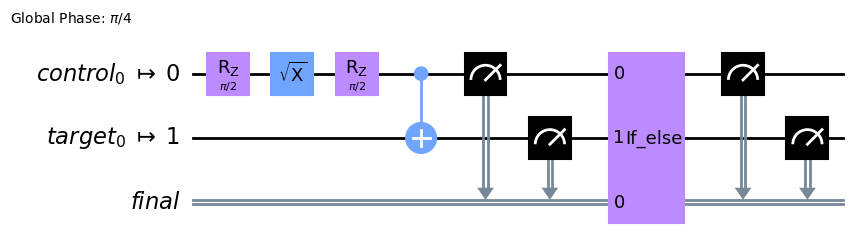

In [29]:
qc_cond_meas = qc_bell.copy()

with qc_cond_meas.if_test((final_measure[0], True)) as else_:
    qc_cond_meas.x(qr[0])
with else_:
    qc_cond_meas.x(qr[1])

qc_cond_meas.measure(qr[0], final_measure)
qc_cond_meas.measure(qr[1], final_measure)

qc_cond_meas.draw("mpl", idle_wires=False)

In [30]:
cond_meas_job = backend.run(qc_cond_meas, shots=1000, dynamic=True)
print(f"Runtime job id: {cond_meas_job.job_id()}")
job_monitor(cond_meas_job)

cond_meas_result = cond_meas_job.result()
print(f"Preparation results: {cond_meas_result.get_counts(0)}")

Runtime job id: cg7r24ikefmul9thmi9g
Job Status: job has successfully run
Preparation results: {'0': 30, '1': 970}


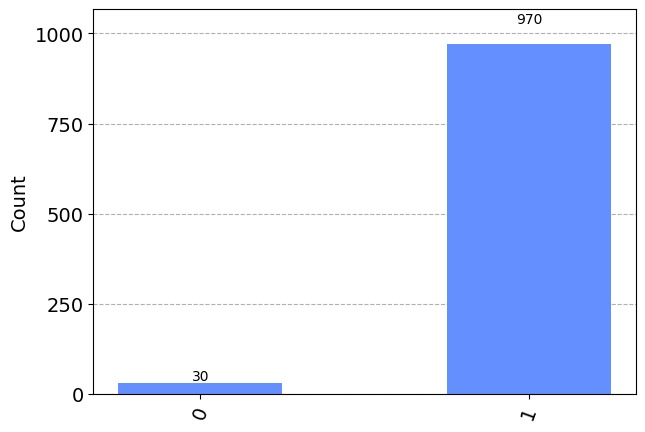

In [31]:
plot_histogram(cond_meas_result.get_counts(0))

A current limitation of conditional measurement is that you cannot extract the results from hardware, but you may still use the results.

Above, we read out the result of the conditional measurement by conditionally applying a gate (here, conditional bit-flip) based on the conditional measurement result, and then applying an unconditional measurement.

This constraint will be relaxed in the future.

---

In [ ]:
import qiskit.tools.jupyter

%qiskit_version_table